### Оценка потенциального экономического эффекта от внедрения полученного решения

In [121]:
## Подготовим модель и данные:
#analyse
import pandas as pd
import numpy as np


# prepare data
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest


#processing
from sklearn.pipeline import Pipeline


#Models
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

## visualise
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix


#ignore warnings
import warnings
warnings.filterwarnings('ignore')


## Построим конечную модель
def dropUninformative(data):
    data=data.copy()
    df = pd.DataFrame([])
    for i in range(data.shape[1]):
        if len(data.iloc[:,i].unique())>1:
            df["Var"+str(i)] = data.iloc[:,i]
    return df

path='/Users/nikli/Documents/git_reps/Data/'
churn_data = pd.read_csv(path+'orange_small_churn_data.txt')
churn_label = pd.read_csv(path+'orange_small_churn_labels.txt',names = ['Labels'])


hurn_data=dropUninformative(churn_data)
churn_data['Labels']=churn_label
churn_data=churn_data.fillna(0)

cols=churn_data.loc[:,'Var190':'Var229'].columns
for col in cols:
    freq_encode = churn_data.groupby(col).size() / churn_data.shape[0]
    churn_data.loc[:, col] = churn_data[col].map(freq_encode)
    
train_data=churn_data.copy()

y=train_data['Labels'] 
x=train_data.drop('Labels', axis=1)

## Делим на обучение и тест
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=123)


selector = SelectKBest(k=45)
selector.fit(X_train, y_train)

X_train = selector.transform(X_train)
X_test = selector.transform(X_test)

import optuna
import sklearn

def objective(trial):

    classifier = trial.suggest_categorical('classifier', ['XGBoost'])
    
    n_estimators = trial.suggest_int('n_estimators', 2, 20)
    gamma=trial.suggest_float('gamma', 0.01, 0.1)
    learning_rate=trial.suggest_float('learning_rate', 0.00001, 2)
    max_depth=trial.suggest_int('max_depth',3, 24)
    colsample_bytree=trial.suggest_float('colsample_bytree', 0.60, 0.98)
    reg_lambda=trial.suggest_int('reg_lambda', 1, 20, log=True)

    clf = XGBClassifier(n_estimators=n_estimators,
                        gamma=gamma,
                        learning_rate=learning_rate,
                        max_depth=max_depth,
                        colsample_bytree=colsample_bytree,
                        reg_lambda=reg_lambda
                                )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    
    f1sc = f1_score(y_test, y_pred)
#     return sklearn.model_selection.cross_val_score(
#         clf, X_f_classif, y_train, n_jobs=-1, cv=4).mean()
    return f1sc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))



# clf = XGBClassifier(n_estimators=7,
#                     gamma=0.01728174027148935,
#                     learning_rate=0.620295165652943,
#                     max_depth=23,
#                     colsample_bytree=0.8387860909193084,
#                     reg_lambda=19
#                                 )

clf = XGBClassifier(n_estimators=trial.params['n_estimators'],
                    gamma=trial.params['gamma'],
                    learning_rate=trial.params['learning_rate'],
                    max_depth=trial.params['max_depth'],
                    colsample_bytree=trial.params['colsample_bytree'],
                    reg_lambda=trial.params['reg_lambda']
                                )

clf.fit(X_train, y_train)

preds_class = clf.predict(X_test)

f1 = f1_score(y_test, preds_class, average='macro')

print(f1)
#print(selector.get_support(indices=True))
cols = ['Var'+str(i) for i in selector.get_support(indices=True)]
## Вернём столбцы датафрейм
train_df=pd.DataFrame(X_train,columns=cols)
test_df=pd.DataFrame(X_test,columns=cols)
train_df

[I 2021-01-21 20:18:20,069] A new study created in memory with name: no-name-36439530-0417-4250-bcc7-00931da899c7
[I 2021-01-21 20:18:20,381] Trial 0 finished with value: 0.031880977683315624 and parameters: {'penalty': 'l2', 'fit_intercept': True, 'C': 0.7340484256839476, 'max_iter': 350}. Best is trial 0 with value: 0.031880977683315624.
[I 2021-01-21 20:18:20,691] Trial 1 finished with value: 0.031880977683315624 and parameters: {'penalty': 'elasticnet', 'fit_intercept': False, 'C': 0.6945274650142742, 'max_iter': 500}. Best is trial 0 with value: 0.031880977683315624.
[I 2021-01-21 20:18:21,012] Trial 2 finished with value: 0.031880977683315624 and parameters: {'penalty': 'elasticnet', 'fit_intercept': False, 'C': 0.5343455968762063, 'max_iter': 700}. Best is trial 0 with value: 0.031880977683315624.
[I 2021-01-21 20:18:21,309] Trial 3 finished with value: 0.031880977683315624 and parameters: {'penalty': 'elasticnet', 'fit_intercept': True, 'C': 0.25224741087490304, 'max_iter': 600

Accuracy: 0.031880977683315624
Best hyperparameters: {'penalty': 'l2', 'fit_intercept': True, 'C': 0.7340484256839476, 'max_iter': 350}
0.49204101877502265


,Var6,Var10,Var12,Var27,Var37,Var64,Var71,Var72,Var73,Var80,...,Var216,Var217,Var219,Var220,Var221,Var224,Var225,Var226,Var227,Var228
0,7.0,0.0,3860.0,323.12,4626834.0,9.0,3.0,128.0,469.0,209301.00,...,0.000050,0.506325,0.000925,0.74025,0.000925,0.221875,0.028175,0.7028,0.086425,0.569425
1,0.0,0.0,0.0,166.56,0.0,9.0,3.0,26.0,0.0,20070.33,...,0.000150,0.506325,0.001000,0.74025,0.001000,0.523375,0.059350,0.7028,0.655275,0.569425
2,7.0,0.0,696.0,255.20,5740806.0,9.0,3.0,34.0,21.0,202584.90,...,0.000200,0.479675,0.000150,0.74025,0.000150,0.523375,0.043375,0.7028,0.655275,0.569425
3,0.0,0.0,0.0,253.52,5364222.0,9.0,0.0,42.0,0.0,35267.10,...,0.000075,0.506325,0.000550,0.74025,0.000550,0.523375,0.052200,0.7028,0.655275,0.569425
4,0.0,0.0,0.0,186.64,5330694.0,9.0,0.0,16.0,0.0,512655.00,...,0.000025,0.506325,0.000750,0.74025,0.000750,0.523375,0.021350,0.7028,0.655275,0.569425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,14.0,0.0,336.0,220.08,4687614.0,18.0,6.0,36.0,217.0,17364.48,...,0.000325,0.479675,0.001650,0.74025,0.001650,0.523375,0.042050,0.7028,0.655275,0.569425
29996,0.0,0.0,0.0,253.52,2851374.0,18.0,6.0,28.0,0.0,216770.10,...,0.000025,0.506325,0.000300,0.74025,0.000300,0.523375,0.042050,0.7028,0.655275,0.569425
29997,7.0,0.0,36.0,280.24,0.0,9.0,0.0,54.0,7.0,41887.80,...,0.000125,0.506325,0.000825,0.74025,0.000825,0.221875,0.098500,0.7028,0.655275,0.232800
29998,0.0,0.0,0.0,325.12,6856200.0,9.0,0.0,28.0,0.0,151551.30,...,0.000975,0.479675,0.000675,0.74025,0.000675,0.523375,0.084650,0.7028,0.655275,0.569425


Построим простую экономическую модель для оценки эффекта от внедрения полученного решения на практике. 

Введём следующие параметры:

- сколько денег в среднем приносит один пользователь в месяц
- сколько денег в среднем вы будете вкладывать в удержание одного пользователя;
- с какой вероятностью пользователь примет ваше предложение;
- сколько пользователей (например, топ 1% или топ 25% согласно ранжированию по вашей модели) будет участвовать в кампании.

### Описание метрик:
- mounth_profit_per_user(_income_per_month/incomeFor1) - сколько денег в среднем приносит один пользователь в месяц (rub)
- retention_cost(_invest/costFor1) - сколько денег в среднем вы будете вкладывать в удержание одного пользователя (rub)
- probability_of_acceptance(_prob_accepting/randomChance) - вероятность пользователя принят ваше предложение 
- share_of_users(_fraction_participants) - доля пользователей (согласно ранжированию модели), которая будет участвовать в кампании
- campaign_period - период оценки эффекта от проведения кампании (месяцев)
- churn_lag - средний период задержки ухода, т.е. интервал между тем как начали использовать модель и клиенты ушли, (месяцев)

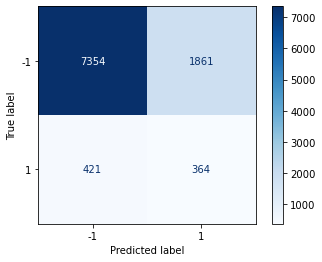

In [117]:
disp = plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

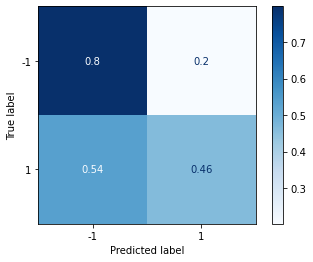

In [118]:
disp = plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, normalize='true')
plt.show()

In [93]:
def economic_model(y_true, predicted, top, mounth_profit_per_user, retention_cost, probability_of_acceptance, call_cost):
    '''
    Создаем DataFrame с предскаазнием,  истинным значением и прибылью.
    
    
    '''
    df_clients = pd.DataFrame([])
    df_clients['predict'] = predicted
    df_clients['y_true'] = y_true
    df_clients['profit'] = 0
    np.random.seed(27)
    rands = pd.DataFrame(data = np.random.random(len(predicted)), columns=['random'])
    """    
    создаем датафрейм с рандомными вероятностями размером=тстовой выборке 
       random
       0  0.425721
       1  0.814584
       2  0.735397
       3  0.868003
       4  0.383381
    """
    df_clients.sort_values('predict', inplace = True, ascending=False)
    # сначачла выводим предсказания, в которых мы 100% уверенны
    threshold = df_clients.iloc[int(len(df_clients)*top)-1, 0]  # Находим попрог predict_prob-ы у топ 10/20/30..100% пользователей
    
    
    profit = 0
    
    
        false_no_churn_user_index=df_clients[(df_clients['predict']<threshold)][(df_clients['y_true'] == 1)].index
    true_no_churn_user_index=df_clients[(df_clients['predict']<threshold)][(df_clients['y_true'] == -1)].index
    true_churn_user_noaccept_index=df_clients[(df_clients['predict']>threshold)][(df_clients['y_true'] == 1)][(rands['random']>probability_of_acceptance)].index
    true_churn_user_accept_index=df_clients[(df_clients['predict']>threshold)][(df_clients['y_true'] == 1)][(rands['random']<probability_of_acceptance)].index
    false_churn_user_index=df_clients[(df_clients['predict']>threshold)][(df_clients['y_true'] == -1)].index
    
    
    #df_clients[(df_clients['predict']>threshold)][(df_clients['y_true'] == 1)][(rands['random']>probability_of_acceptance)]
    
    df_clients['profit'].loc[false_no_churn_user_index] = 0 # пользователь ушёл от нас, но мы предположили и мы ничего не сделали
    df_clients['profit'].loc[true_no_churn_user_index] = mounth_profit_per_user # пользователь остался и мы ничего не сделали
    df_clients['profit'].loc[true_churn_user_noaccept_index]= 0-call_cost # пользователь ушёл , и не принял предложение мы ему звонили и предлагали скидку 
    df_clients['profit'].loc[true_churn_user_accept_index]= mounth_profit_per_user-retention_cost # Мы вернули пользователя позвонив и предложив скидку
    df_clients['profit'].loc[false_churn_user_index] = mounth_profit_per_user-retention_cost # Мы ошибочно предложили пользователю скидку 
    
    profit = sum(df_clients['profit']) # Считаем конечную прибыль компании
    
    statistic = stats(df_clients, top, profit, mounth_profit_per_user, retention_cost, 0.2, probability_of_acceptance)
    return profit, df_clients, statistic

In [94]:
def stats(df, top, profit, mounth_profit_per_user, retention_cost, churn, chance):
    count_stayed_user= len(df[df['y_true']== -1])
    count_churn_user= len(df[df['y_true']== 1])
    """
    Cоздаем датафрейм со всей статистикой:
    1) % пользователей, которых мы считаем оттоком по вероятности модели
    2) Скролько денег принесёт бизнес без модели (число пользователей,которые остануться * месячный доход)
    3) Сколько денег принесёт бизнес, если мы всем предложим скидку (число ВСЕХ пользователей * месячный доход со скидкой - доля пользователей, которые все равно ушли*месячный доход со скидкой  )
    4) Число всех юзеров до предикта len(df)
    5) Число пользователей после без предикта len(df[df['y_true']== -1])
    6) Число всех оставшихся юзеров после с предиктом  len(df[df['profit']>0])
    7) Прибыль в след месяце без предикта = число оставшихся юзеров * прибыль без скидки
    8) Прибыль в след месяце с предиктом = число юзеров с предиктом * месячную прибыль без скидки
    """
    count_user=len(df)
    
    temp = pd.DataFrame([[top,
                        len(df)*(1-churn)*mounth_profit_per_user,
                        len(df)*1.*(mounth_profit_per_user-retention_cost) - len(df[df['y_true']==-1])*churn*(mounth_profit_per_user)*(1-chance),
                        profit,
                        len(df),
                        len(df[df['y_true']==-1]),#int(len(df)*(1-churn)),
                        len(df[(df['profit']>0)][(df['y_true'] == 1)]) +len(df[df['y_true']==-1]), #len(df[df['profit']>0]), #
                        len(df)*mounth_profit_per_user*0.8,
                        len(df[df['profit']>0])*mounth_profit_per_user]],
                        columns=['top of predicted clients',
                                'profit without anything',
                                'profit with all called clients',
                                'profit with predicted clients',
                                'number of clients before predict',
                                'number of clients after no predict',
                                'number of clients after predict',
                                'profit in next time(no predict, next month with action)',
                                'profit in next time(predict, next month with action)'])
    return temp

In [95]:
def plot_income(y_true, predicted, mounth_profit_per_user, retention_cost, probability_of_acceptance, call_cost):
    print('Строим граффик доходности ...')
    tops = np.linspace(0.0005,1., num = 500)  # Ось Х хз что означает
    
    incomes = []
    statistic = pd.DataFrame([])
    print('считаем прибыль с помощью экономической модели...')
    for top in tops:
        incomes.append(economic_model(y_true, predicted, top, mounth_profit_per_user, retention_cost, probability_of_acceptance, call_cost)[0])
        statistic=statistic.append(economic_model(y_true, predicted, top, mounth_profit_per_user, retention_cost, probability_of_acceptance, call_cost)[2], ignore_index=True)
    
    plt.figure(figsize=(20,10))
    plt.title(u"график зависимости полученной прибыли от топа прогнозируемых клиентов после проведения кампании по удержанию")
    plt.xlabel("Top")
    plt.ylabel("Profit")
    plt.plot(tops, incomes, color="g", label=u"прибыль с учетом прогноза оттока")
    plt.plot(tops[0], incomes[0], 'ro', label = u'соответствует значению без удержания клиентов')
    plt.plot(tops[-1], incomes[-1], 'bo', label = u'соответствует значению после опроса всех клиентов')
    df = pd.DataFrame([])
    df['Profit'] = incomes
    df['Top'] = tops
    plt.legend(loc="best")
    return df, statistic

In [97]:
print(clf.predict_proba(test_df.iloc[:,:45].values)[:,1])
print(clf.predict(test_df.iloc[:,:45].values))
print(y_test.values)

[1.4152397e-06 3.4799802e-01 2.2938881e-04 ... 4.3684009e-02 8.8817298e-02
 1.4610732e-01]
[-1 -1 -1 ... -1 -1 -1]
[-1 -1 -1 ... -1 -1 -1]


Строим граффик доходности ...
считаем прибыль с помощью экономической модели...


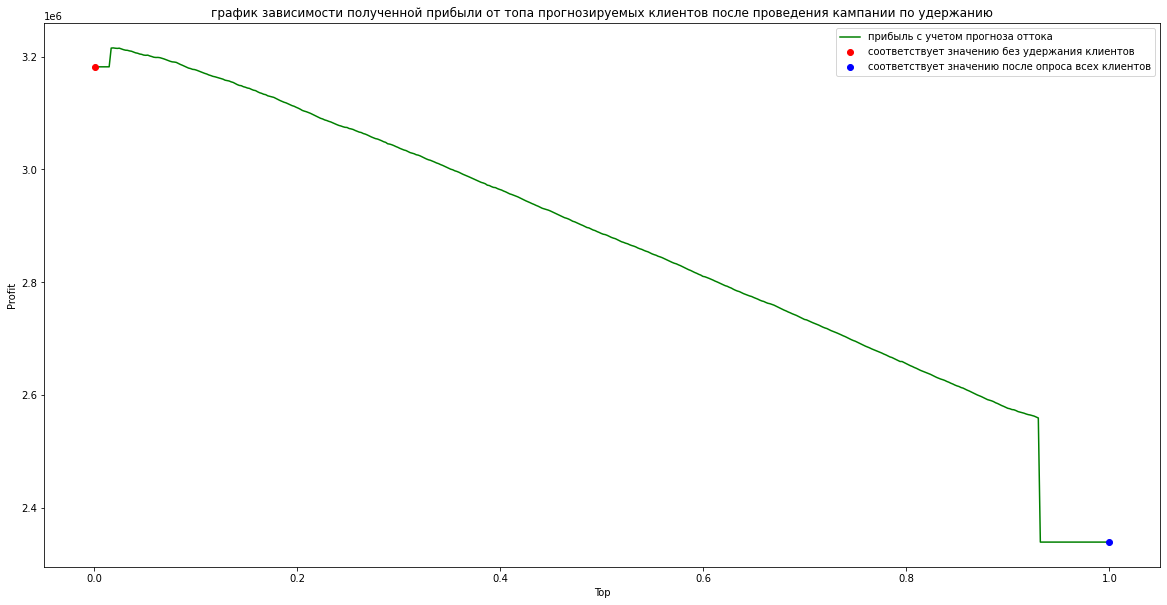

In [104]:
predicted = clf.predict_proba(test_df.iloc[:,:45].values)[:,1]
mounth_profit_per_user = 350. # Среднее число денег,которые приносит нам пользователь
call_cost = 20 # стоимость звонка
retention_cost = call_cost + 0.20*mounth_profit_per_user # стоимость возврата пользователя
probability_of_acceptance = 0.60 # Вероятность принятия предложения
statistic = plot_income(y_test.values, predicted, mounth_profit_per_user,
                        retention_cost, probability_of_acceptance, call_cost)[1]

In [105]:
statistic

,top of predicted clients,profit without anything,profit with all called clients,profit with predicted clients,number of clients before predict,number of clients after no predict,number of clients after predict,"profit in next time(no predict, next month with action)","profit in next time(predict, next month with action)"
0,0.000500,2800000.0,2341980.0,3181850.0,10000,9215,9215,2800000.0,3181850.0
1,0.002503,2800000.0,2341980.0,3181850.0,10000,9215,9215,2800000.0,3181850.0
2,0.004506,2800000.0,2341980.0,3181850.0,10000,9215,9215,2800000.0,3181850.0
3,0.006509,2800000.0,2341980.0,3181850.0,10000,9215,9215,2800000.0,3181850.0
4,0.008512,2800000.0,2341980.0,3181850.0,10000,9215,9215,2800000.0,3181850.0
...,...,...,...,...,...,...,...,...,...
495,0.991988,2800000.0,2341980.0,2340060.0,10000,9215,9649,2800000.0,3157700.0
496,0.993991,2800000.0,2341980.0,2340060.0,10000,9215,9649,2800000.0,3157700.0
497,0.995994,2800000.0,2341980.0,2340060.0,10000,9215,9649,2800000.0,3157700.0
498,0.997997,2800000.0,2341980.0,2340060.0,10000,9215,9649,2800000.0,3157700.0


Строим граффик доходности ...
считаем прибыль с помощью экономической модели...


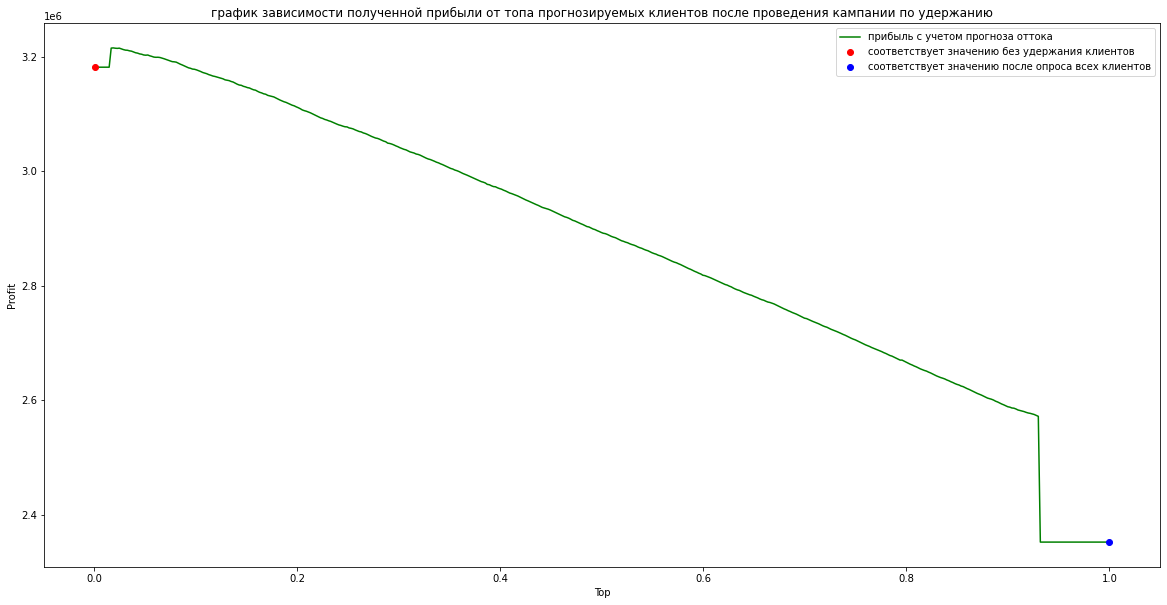

In [106]:
statistic_second_month = plot_income(y_test.values, predicted, mounth_profit_per_user, retention_cost-1.3, probability_of_acceptance, call_cost)[1]

In [107]:
def plot_stats(df):
    plt.figure(figsize=(20,10))
    plt.xlabel("Top")
    plt.ylabel("Profit")
    plt.plot(df.iloc[:,0], df.iloc[:,1], '--', color="r", label=u"прибыль с % оттока")
    plt.plot(df.iloc[:,0], df.iloc[:,2], '--',color="k", label=u"прибыль с учетом обзвона всех клиентов")
    plt.plot(df.iloc[:,0], df.iloc[:,3],color="g", label=u"прибыль с учетом прогноза оттока")
    plt.plot(df.iloc[:,0], df.iloc[:,8],color="b", label=u"прибыль в будущем (после прогноза и затрат)")
    plt.title(u"график зависимости полученной прибыли от топа прогнозируемых клиентов после проведения кампании по удержанию")
    plt.legend(loc="best")

In [108]:
statistic

,top of predicted clients,profit without anything,profit with all called clients,profit with predicted clients,number of clients before predict,number of clients after no predict,number of clients after predict,"profit in next time(no predict, next month with action)","profit in next time(predict, next month with action)"
0,0.000500,2800000.0,2341980.0,3181850.0,10000,9215,9215,2800000.0,3181850.0
1,0.002503,2800000.0,2341980.0,3181850.0,10000,9215,9215,2800000.0,3181850.0
2,0.004506,2800000.0,2341980.0,3181850.0,10000,9215,9215,2800000.0,3181850.0
3,0.006509,2800000.0,2341980.0,3181850.0,10000,9215,9215,2800000.0,3181850.0
4,0.008512,2800000.0,2341980.0,3181850.0,10000,9215,9215,2800000.0,3181850.0
...,...,...,...,...,...,...,...,...,...
495,0.991988,2800000.0,2341980.0,2340060.0,10000,9215,9649,2800000.0,3157700.0
496,0.993991,2800000.0,2341980.0,2340060.0,10000,9215,9649,2800000.0,3157700.0
497,0.995994,2800000.0,2341980.0,2340060.0,10000,9215,9649,2800000.0,3157700.0
498,0.997997,2800000.0,2341980.0,2340060.0,10000,9215,9649,2800000.0,3157700.0


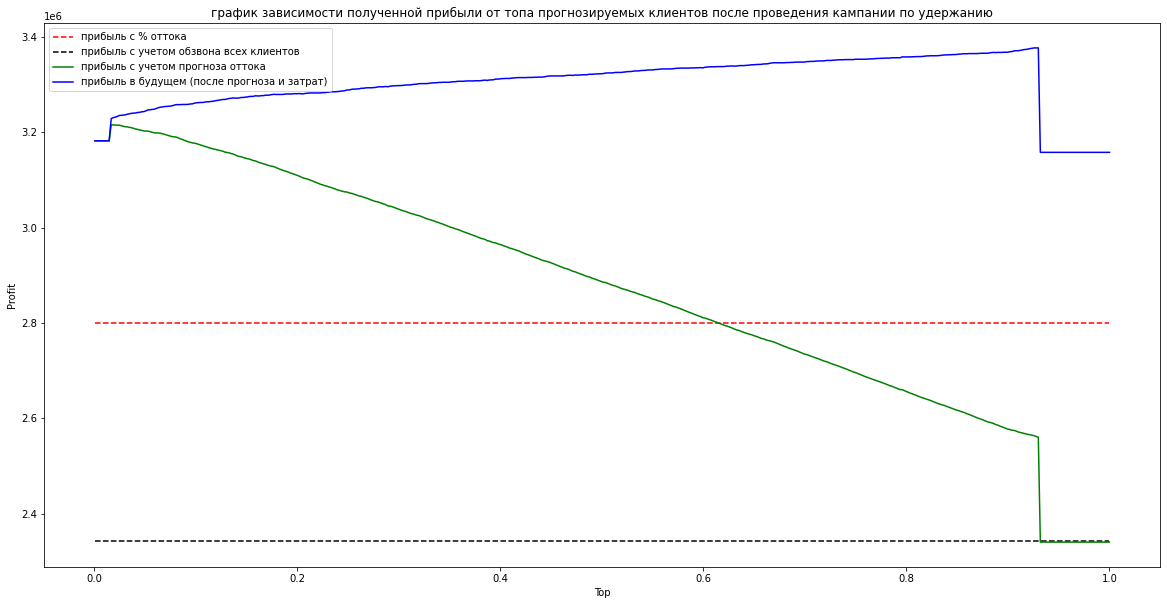

In [109]:
plot_stats(statistic)

### Видно ,что модель дает прирост при +- 5% верхней границы вероятности принаджежности к классу отток. 
### 3. Попробуем усложнить экономическую модель. Добавьте еще несколько параметров и поиграйте с ними (например, измените стоимость удержания и вероятность, с которой пользователь принимает предложение), проанализируйте как меняется оптимальный размер топа?


Строим граффик доходности ...
считаем прибыль с помощью экономической модели...


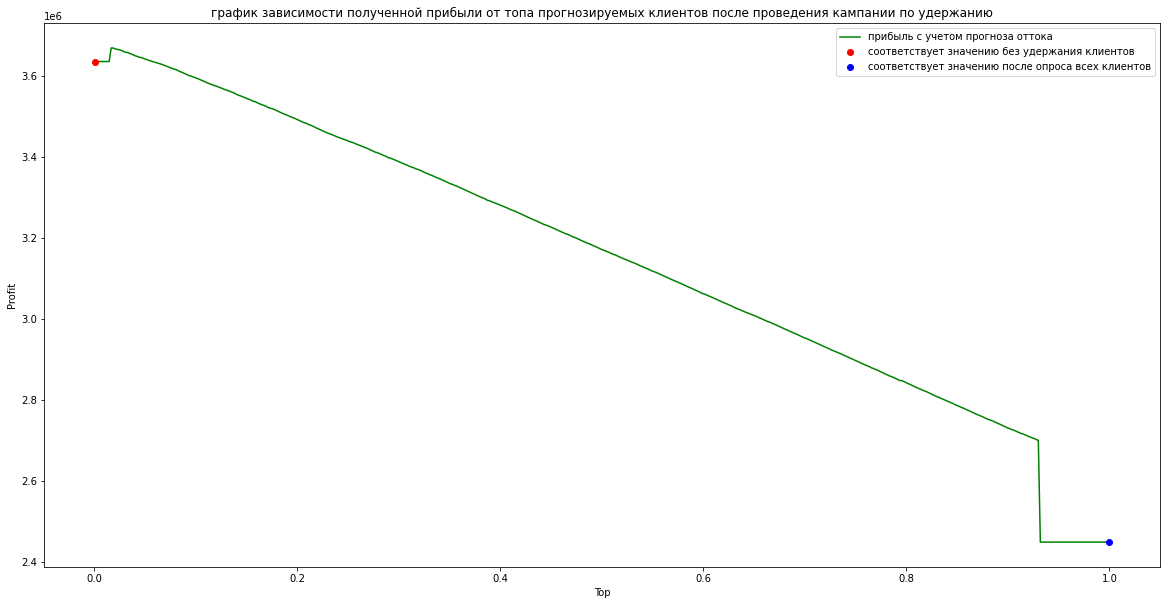

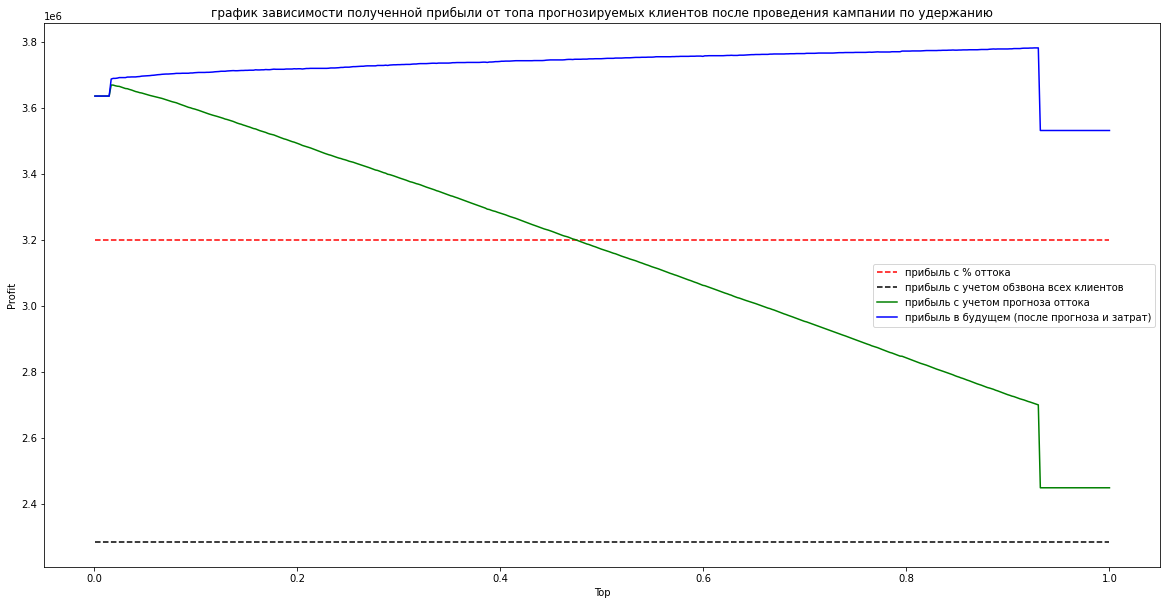

In [111]:
predicted = clf.predict_proba(test_df.iloc[:,:45].values)[:,1]
mounth_profit_per_user2 = 400. # Среднее число денег,которые приносит нам пользователь
call_cost2 = 50 # стоимость звонка
retention_cost2 = call_cost2 + 0.20*mounth_profit_per_user # стоимость возврата пользователя
probability_of_acceptance2 = 0.30 # Вероятность принятия предложения
statistic2 = plot_income(y_test.values, predicted, mounth_profit_per_user2,
                        retention_cost2, probability_of_acceptance2, call_cost2)[1]

plot_stats(statistic2)

### 4. Всегда ли применение модели экономически оправданно? Приведём пример набора значений параметров, при которых применение модели перестает быть оправданным.

Строим граффик доходности ...
считаем прибыль с помощью экономической модели...


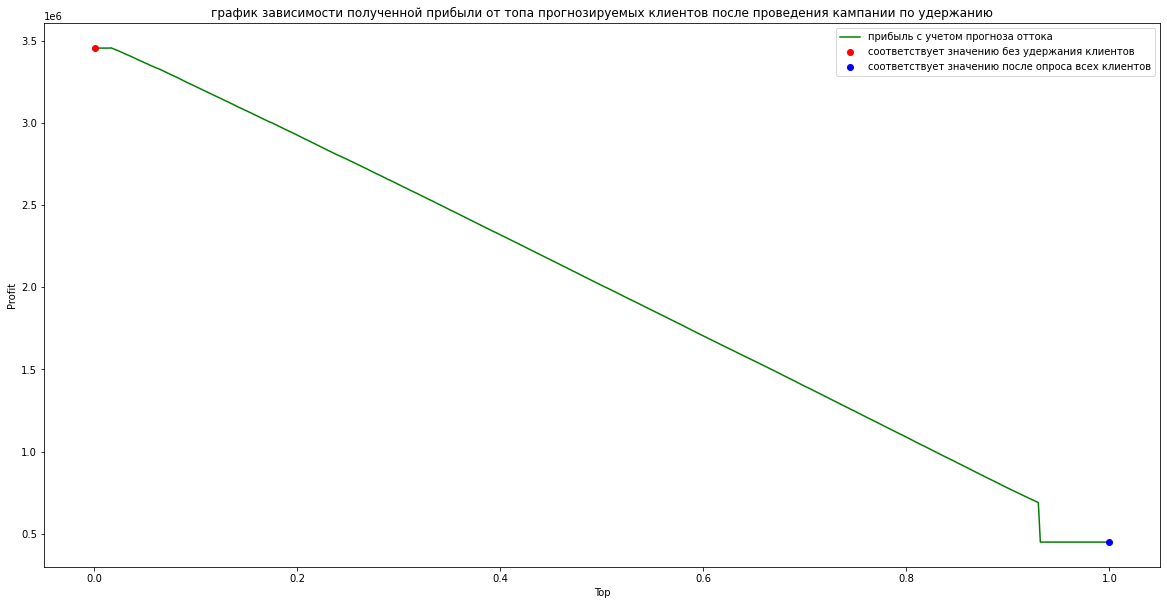

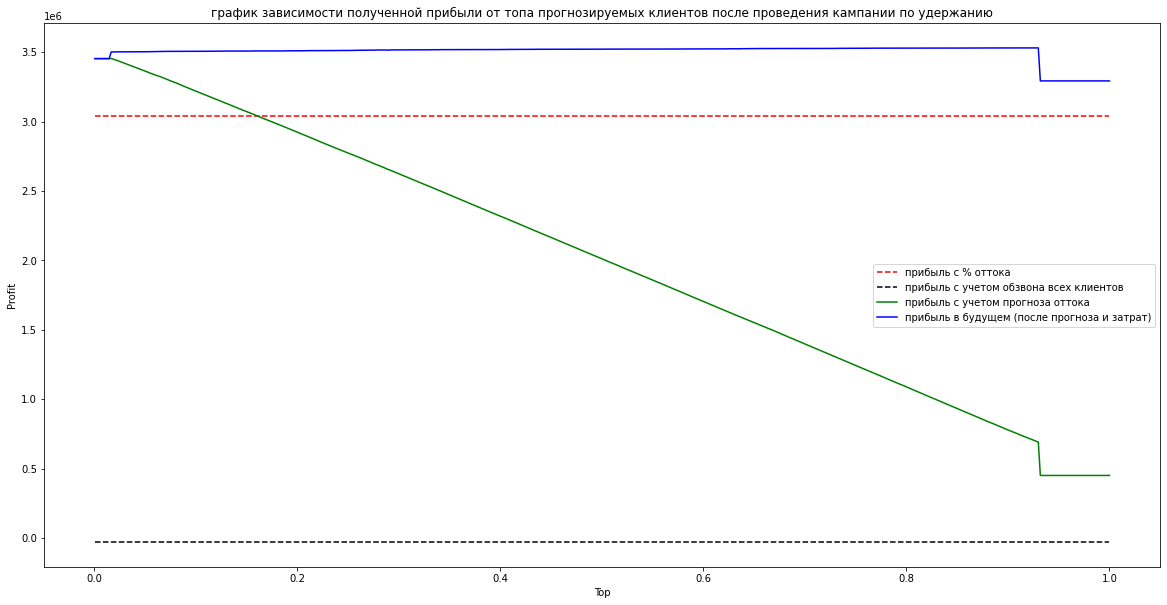

In [115]:
predicted = clf.predict_proba(test_df.iloc[:,:45].values)[:,1]
mounth_profit_per_user2 = 380. # Среднее число денег,которые приносит нам пользователь
call_cost2 = 110 # стоимость звонка
retention_cost2 = call_cost2 + 0.60*mounth_profit_per_user # стоимость возврата пользователя
probability_of_acceptance2 = 0.10 # Вероятность принятия предложения
statistic2 = plot_income(y_test.values, predicted, mounth_profit_per_user2,
                        retention_cost2, probability_of_acceptance2, call_cost2)[1]

plot_stats(statistic2)

### При больших затратах на связь с клиентом - данная модель не будет давать какого-либо эффекта. При большой скидке и малой вероятности принятия скидки - модель не принесёт прибыли в будущем. 


### 5. Оценим изменение экономического эффекта от проведения кампании по удержанию при увеличении качества модели на 1% На 3% 

* Для оценки качества бинарного классификатора я использовал метрику , основанную на евристике - F1 score. увеличение F метрики на 1-3% позволит совершать меньше ошибочных звонков или будет находить уходящих клиентов.

### 6. Является ли экономически оправданным вложение средств в улучшение качества модели? На сколько нужно улучшить модель, чтобы это качественно сказалось на экономическом эффекте от удержания?

Всё зависит от данных, на которых будет применяться модель: Нам нужно знать,сколько месяев используют продукт наши пользователи после того, как мы предложили им услуги для предотвращения оттока, нам так же важно знать,сколько они будут приносить денег в среднем, сколько будут стоить звонки клиенту. Основная идея модели: возвращать пользователей, с помощью разовых затрат на них с целью дальнейшей окупаемости. Качество модели зависит от того, как долго она будет окупать свои расходы.